In [14]:
import warnings
from collections import Counter
import numpy as np
import csv
import networkx as nx
from cdlib import ensemble
from cdlib import algorithms
from cdlib import viz
from cdlib import evaluation
from cdlib import NodeClustering

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Community Discovery of r/conspiracy subreddit

## Network creation

As a first step we need to define the network topology

In [15]:
# function to create the graph from a file csv
def read_net(filename):
    g = nx.Graph()
    with open(filename) as f:
        f=csv.reader(f)
        for l in f:
            g.add_edge(l[0], l[1])
    return g

# function to read the attributes of the nodes from a file csv 
def attributes_nodes(filename,g):
    with open(filename) as f:
        f = csv.reader(f)
        for l in f:
            attributes = [attr.strip() for attr in l[1:]]
            attributes_dict = dictionary_attr(attributes)
            g.nodes[l[0]].update(attributes_dict)
    return g

# function to create the weighted graph from a file csv
def read_net_weighted(filename):
    M = nx.MultiGraph()
    with open(filename) as f:
        f=csv.reader(f)
        for l in f:
            M.add_edge(l[0], l[1])
            
    P = nx.Graph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if P.has_edge(u,v):
            P[u][v]['weight'] += w
        else:
            P.add_edge(u, v, weight=w)
    return P

#### Support function to write in a useful way the attributes of the nodes

In [16]:
def dictionary_attr(attributes):
# topic = -1 indicates that the user doesn't talk about that specif topic
# topic = 1 indicates that the user talks about that specif topic
    covid=-1
    chem=-1
    fiveg=-1
    flat_earth=-1
    alien=-1
    religion=-1
    neutral=-1
# neutral = -1 indicates that the user talks about at least 1 conspiracy
# neutral = 1 indicates that the user doesn't talk about any conspiracy
    if 'covid' in attributes:
        covid=1
    if 'chem' in attributes:
        chem=1
    if '5g' in attributes:
        fiveg=1
    if 'flat_earth' in attributes:
        flat_earth=1
    if 'alien' in attributes:
        alien=1
    if 'religion' in attributes:
        religion=1
    if 'neutral' in attributes:
        neutral=1

    attributes_dict= dict({'covid': covid, 'chem': chem,'fiveg': fiveg,'alien': alien,'religion': religion, 'flat_earth':flat_earth, 'neutral': neutral})

    return attributes_dict


### Function fo the plot of internal density vs size of the communities

In [17]:
def plot_size_vs_density(coms,label):
    i=0
    for c in coms:
        densities = []
        sizes = []
        var_name = label[i]
        i+=1
        for community in c.communities:
            density= nx.density(g.subgraph(community))  # Calculate internal density
            size = len(community) 
            densities.append(density)
            sizes.append(size)
        plt.scatter(sizes,densities,label=var_name)
    plt.legend()
    plt.xlabel('Community Size')
    plt.ylabel('Internal Density')

### Read the network with attributes

We remove the selfloops, the bot and isolated nodes   

In [24]:
g = read_net(f'Conspiracy/conspiracy_2m_final.csv')
g = attributes_nodes(f'Conspiracy/conspiracy_2m_attr.csv',g)
g_weighted = read_net_weighted(f'Conspiracy/conspiracy_2m_final.csv')

#remove the bot
g.remove_node("rConBot")
#remove the bot
g_weighted.remove_node("rConBot")


#remove the selfloops
g.remove_edges_from(nx.selfloop_edges(g))
#remove isolated nodes
g.remove_nodes_from(list(nx.isolates(g)))


#remove the selfloops
g_weighted.remove_edges_from(nx.selfloop_edges(g_weighted))
#remove isolated nodes
g_weighted.remove_nodes_from(list(nx.isolates(g_weighted)))

#copy of the graph
g_copy=g.copy()

We considered only giant component

In [5]:
#considering only giant component
comps = list(nx.connected_components(g))

g=g.subgraph(comps[0])

comps = list(nx.connected_components(g_weighted))

g_weighted=g_weighted.subgraph(comps[0])

Construction of a barabasi-Albert graph to test community algorithms 

In [6]:
m = 7
# B-A random network
ba = nx.barabasi_albert_graph(35310, m)

## Community Discovery algorithm(s) selection and configuration
After having defined the graph, we can select the algorithm(s) to partition it.

We use ensamble methods to choose the best algorithms parameters

### Leiden algorithm

In [7]:
leiden_coms = algorithms.leiden(g)

### Label propagation algorithm

In [51]:
lp_coms = algorithms.label_propagation(g)
lp_ba_coms = algorithms.label_propagation(ba)

### Louvain algorithm

In [8]:
resolution = ensemble.Parameter(name="resolution", start=0.7, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")
louvain_coms, scoring = ensemble.grid_search(graph=g, method=algorithms.louvain,
                                                     parameters=[resolution, randomize],
                                                     quality_score=evaluation.conductance,
                                                     aggregate=min)
print("Best_parameters: ", louvain_coms.method_parameters)
print("Conductance: ", scoring)

Best_parameters:  {'weight': 'weight', 'resolution': 0.9999999999999999, 'randomize': True}
Conductance:  FitnessResult(min=0.14285714285714285, max=0.7496588028855528, score=0.4677971875676803, std=0.13702656901198262)


### Infomap algorithm

In [10]:
infomap_coms = algorithms.infomap(g)
infomap_coms_weighted=algorithms.infomap(g_weighted)

### Angel algorithm

In [41]:
threshold = ensemble.Parameter(name="threshold", start=0.3, end=0.6, step=0.1)
min_size = ensemble.Parameter(name="min_community_size", start=3, end=4, step=1)
angel_coms, scoring = ensemble.grid_search(graph=g, method=algorithms.angel,
                                                     parameters=[min_size, threshold],
                                                     quality_score=evaluation.newman_girvan_modularity,
                                                     aggregate=max)
print("Best_parameters: ", angel_coms.method_parameters)
print("Modularity: ", scoring)

Best_parameters:  {'threshold': 0.5, 'min_community_size': 3}
Modularity:  FitnessResult(min=None, max=None, score=-0.5542899490964496, std=None)


### Demon algorithm

In [40]:
threshold = ensemble.Parameter(name="epsilon", start=0.2, end=0.6, step=0.1)
min_size = ensemble.Parameter(name="min_com_size", start=4, end=6, step=1)
demon_coms, scoring = ensemble.grid_search(graph=g, method=algorithms.demon,
                                                     parameters=[min_size, threshold],
                                                     quality_score=evaluation.newman_girvan_modularity,
                                                     aggregate=max)

print("Best_parameters: ", demon_coms.method_parameters)
print("Modularity: ", scoring)

Best_parameters:  {'epsilon': 0.5000000000000001, 'min_com_size': 4}
Modularity:  FitnessResult(min=None, max=None, score=-0.0018328353908113827, std=None)


## Definition of the function to evualuate the algorithms

- N_coms is the number of community detected 
- Node coverage is the percentage of nodes that are part of a community
- Overlapping is a measure of the overlap between communities
- Conductance
- Modularity
- Average internal degree
- Internal edge density


In [13]:
def evaluate (coms):
    print("N_coms:", len(coms.communities))
    print("Node coverage: ", coms.node_coverage)
    print("Overlapping: ", coms.overlap)
    print("Number of nodes: ", coms.size())
    print("Conductance: ", coms.conductance())
    print("Newman Girvan modularity: ", coms.newman_girvan_modularity())
    print("Average internal degree: ", coms.average_internal_degree())
    print("Internal edge density: ", coms.internal_edge_density())
    
    return

In [14]:
evaluate(leiden_coms)

N_coms: 89
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=2, max=8922, score=393.44943820224717, std=1534.025269786121)
Conductance:  FitnessResult(min=0.2, max=0.7476844458639412, score=0.5293785197287632, std=0.13059700271721775)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.2659539032239119, std=None)
Average internal degree:  FitnessResult(min=1.0, max=11.682574611470224, score=1.757159154915822, std=1.4726504655328356)
Internal edge density:  FitnessResult(min=0.0006002631376672087, max=1.0, score=0.5560078159566525, std=0.3648587143969362)


In [52]:
evaluate(lp_coms)
evaluate(lp_ba_coms)

N_coms: 338
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=2, max=34254, score=103.60059171597634, std=1860.2908955893604)
Conductance:  FitnessResult(min=0.0013066065947164747, max=0.6, score=0.4234896747627165, std=0.09091627179073337)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.0035759640217215023, std=None)
Average internal degree:  FitnessResult(min=1.0, max=13.990833187364979, score=1.1194431525689863, std=0.7230924618179704)
Internal edge density:  FitnessResult(min=0.00040845570278121566, max=1.0, score=0.923923440063364, std=0.16265232188643297)
N_coms: 1
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=35093, max=35093, score=35093.0, std=0.0)
Conductance:  FitnessResult(min=0.0, max=0.0, score=0.0, std=0.0)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.0, std=None)
Average internal degree:  FitnessResult(min=13.997207420283248, max=13.997207420283248, score=13.997207420283

In [16]:
evaluate(louvain_coms)

N_coms: 95
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=2, max=7991, score=368.6, std=1431.9420041181468)
Conductance:  FitnessResult(min=0.14285714285714285, max=0.7435897435897436, score=0.47048994371353964, std=0.1414638971610205)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.24549091185555663, std=None)
Average internal degree:  FitnessResult(min=1.0, max=12.114249843063403, score=1.5890189240989072, std=1.4422574999565936)
Internal edge density:  FitnessResult(min=0.0005951651608400528, max=1.0, score=0.6679487492365518, std=0.38134463684432285)


In [17]:
evaluate(infomap_coms)
evaluate(infomap_coms_weighted)

N_coms: 2080
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=2, max=15095, score=16.835096153846155, std=330.7428079615035)
Conductance:  FitnessResult(min=0.14285714285714285, max=0.85, score=0.6617504108961249, std=0.11069900692070356)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.13780765038065573, std=None)
Average internal degree:  FitnessResult(min=1.0, max=19.101159324279564, score=1.715263177379358, std=0.5254502461405763)
Internal edge density:  FitnessResult(min=0.0012654802785397883, max=1.0, score=0.35204958347750726, std=0.30671829148377305)
N_coms: 2030
Node coverage:  1.0
Overlapping:  False
Number of nodes:  FitnessResult(min=2, max=373, score=17.24975369458128, std=16.97068429837457)
Conductance:  FitnessResult(min=0.16666666666666666, max=0.949740034662045, score=0.7601336214174367, std=0.13070453925405864)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.2250681094063042, std=None)
Average interna

In [42]:
evaluate(angel_coms)

N_coms: 49
Node coverage:  0.3473741325641831
Overlapping:  True
Number of nodes:  FitnessResult(min=3, max=12036, score=249.51020408163265, std=1701.234415243873)
Conductance:  FitnessResult(min=0.12124383602325008, max=1.0, score=0.877935260179852, std=0.16769865737380762)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=-0.5542899490964496, std=None)
Average internal degree:  FitnessResult(min=0.0, max=30.48537720172815, score=2.225041711599894, std=4.1545987552871875)
Internal edge density:  FitnessResult(min=0.0, max=0.8333333333333334, score=0.5756833763461395, std=0.23320369822378806)


In [19]:
evaluate(demon_coms)

N_coms: 113
Node coverage:  0.3832138675500471
Overlapping:  True
Number of nodes:  FitnessResult(min=5, max=8454, score=868.3451327433628, std=1834.5326031536838)
Conductance:  FitnessResult(min=0.1871750523562937, max=0.9830208701804033, score=0.8190870772091778, std=0.2158656477776641)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=-0.0018328353908113827, std=None)
Average internal degree:  FitnessResult(min=2.8, max=50.67422810333964, score=16.83232326626323, std=14.951332151201244)
Internal edge density:  FitnessResult(min=0.0043666770582525775, max=0.7, score=0.20103499507191644, std=0.21970012484857995)


## External evaluation

It is useful to compare the different graph partitions.

### Adjusted Mutual Information

Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. 

In [20]:
print(evaluation.adjusted_mutual_information(louvain_coms,leiden_coms))

MatchingResult(score=0.19137762073869277, std=None)


In [21]:
print(evaluation.adjusted_mutual_information(louvain_coms,lp_coms))

MatchingResult(score=0.04543476549078264, std=None)


In [22]:
print(evaluation.adjusted_mutual_information(louvain_coms,leiden_coms))

MatchingResult(score=0.19137762073869277, std=None)


In [23]:
print(evaluation.adjusted_mutual_information(louvain_coms,infomap_coms))

MatchingResult(score=0.20055213207970116, std=None)


In [24]:
print(evaluation.adjusted_mutual_information(leiden_coms,lp_coms))

MatchingResult(score=0.0382791885393894, std=None)


In [25]:
print(evaluation.adjusted_mutual_information(leiden_coms,infomap_coms))

MatchingResult(score=0.18370561350235512, std=None)


In [26]:
print(evaluation.adjusted_mutual_information(lp_coms,infomap_coms))

MatchingResult(score=0.04323632069317259, std=None)


### Overlapping normalized mutual information LFK
Extension of the Normalized Mutual Information (NMI) score to cope with overlapping partitions.

In [43]:
print(evaluation.overlapping_normalized_mutual_information_LFK(angel_coms,demon_coms))

MatchingResult(score=0.18965081363015068, std=None)


## Plots (Visual analytics)

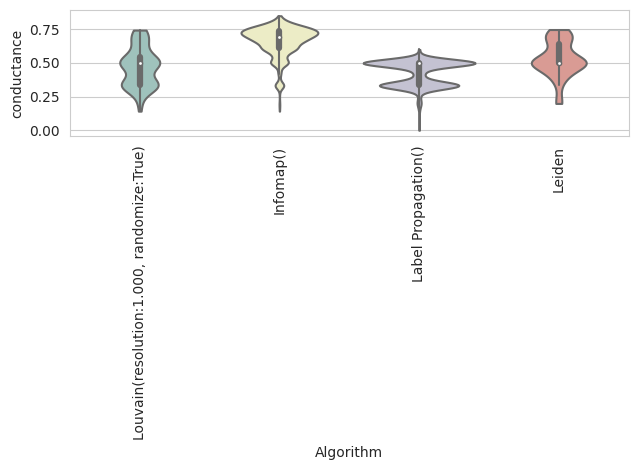

In [34]:
violinplot = viz.plot_com_stat([louvain_coms,infomap_coms,lp_coms,leiden_coms], evaluation.conductance)
plt.savefig('violin1.png')

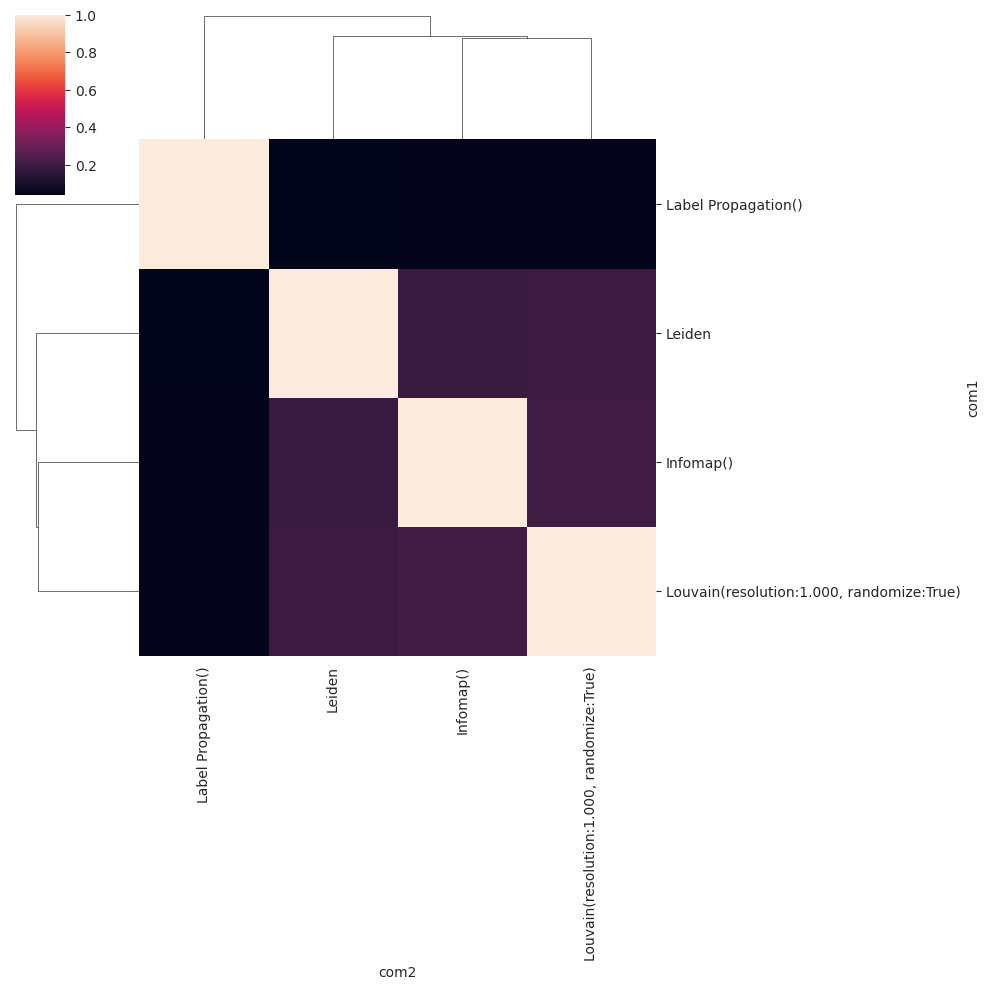

In [35]:
clustermap = viz.plot_sim_matrix([louvain_coms,infomap_coms,lp_coms,leiden_coms],evaluation.adjusted_mutual_information)
plt.savefig('mutual1.png')

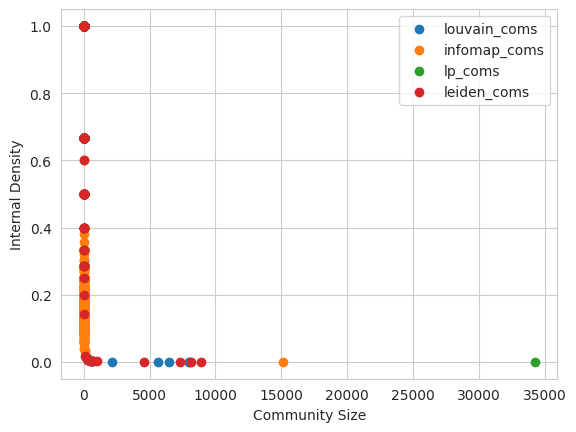

In [36]:
plot_size_vs_density([louvain_coms,infomap_coms,lp_coms,leiden_coms],['louvain_coms','infomap_coms','lp_coms','leiden_coms'])
plt.savefig('des_vs_size1.png')

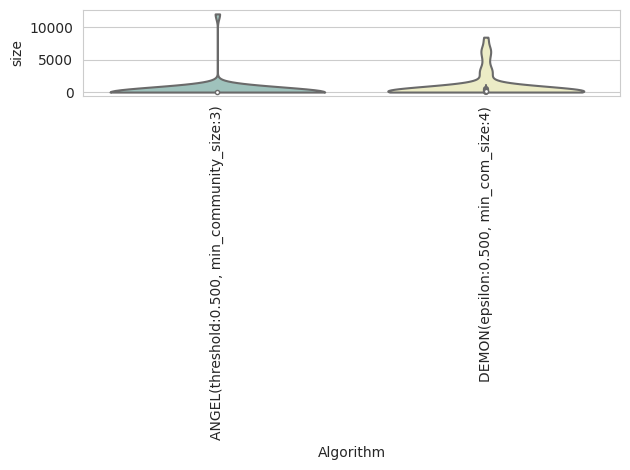

In [44]:
violinplot = viz.plot_com_stat([angel_coms,demon_coms],evaluation.size)
plt.savefig('violin2.png')

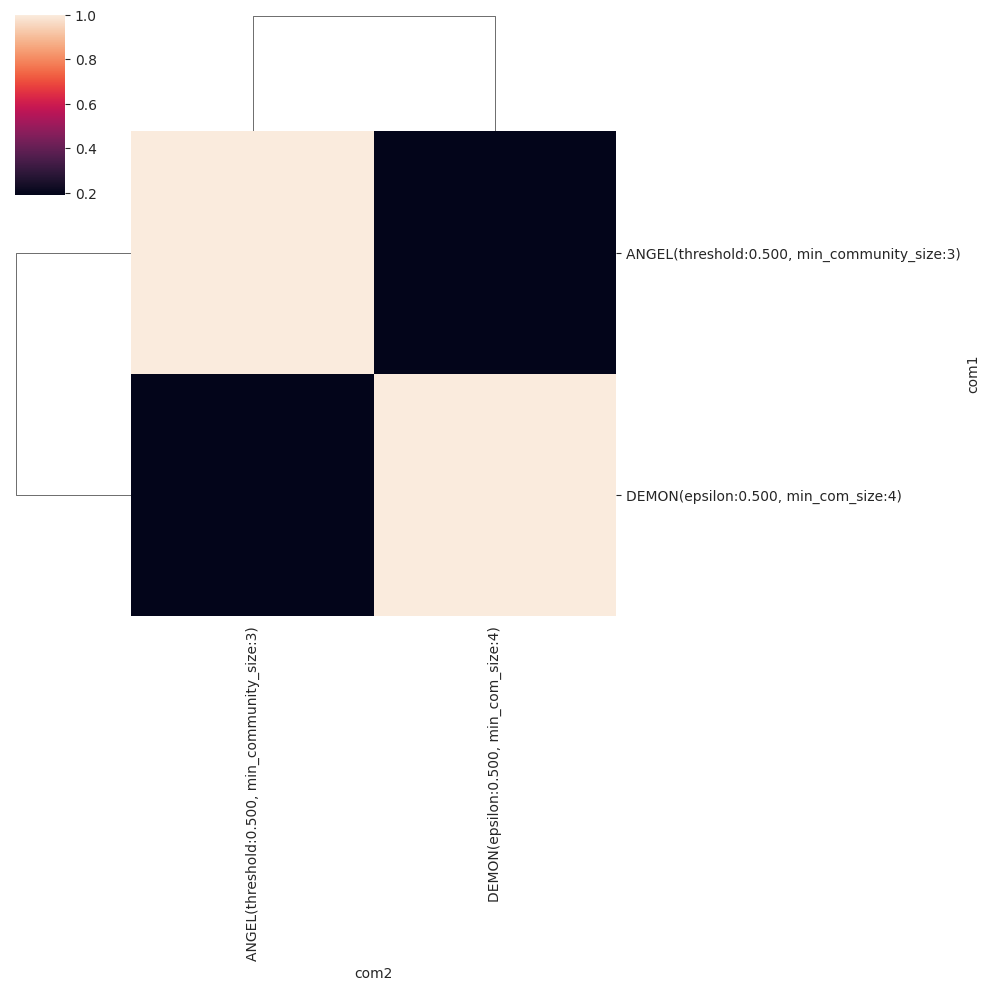

In [45]:
clustermap = viz.plot_sim_matrix([angel_coms,demon_coms],evaluation.overlapping_normalized_mutual_information_LFK)

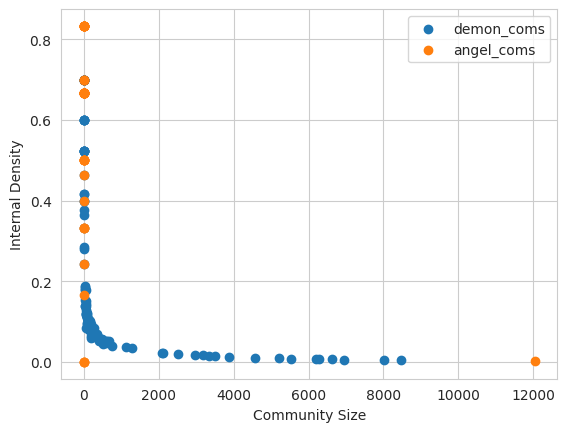

In [46]:
plot_size_vs_density([demon_coms,angel_coms],['demon_coms','angel_coms'])
plt.savefig('des_vs_size2.png')

### Plot of the communities of the graph for different algorithms

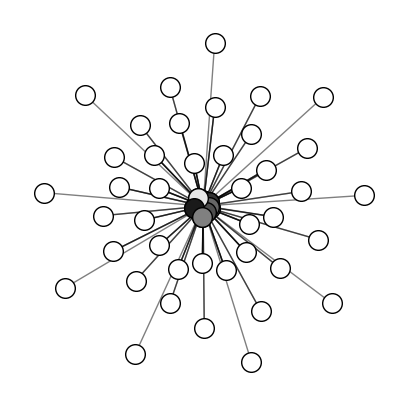

In [48]:
viz.plot_community_graph(g, leiden_coms, figsize=(5, 5), min_size=3)

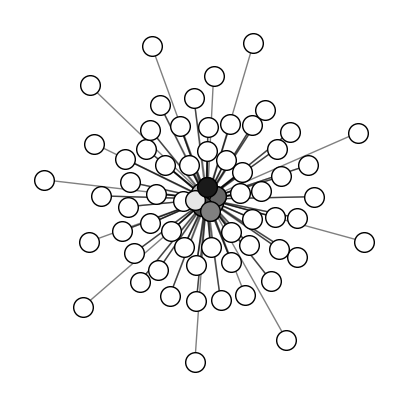

In [49]:
viz.plot_community_graph(g, louvain_coms, figsize=(5, 5), min_size=3)

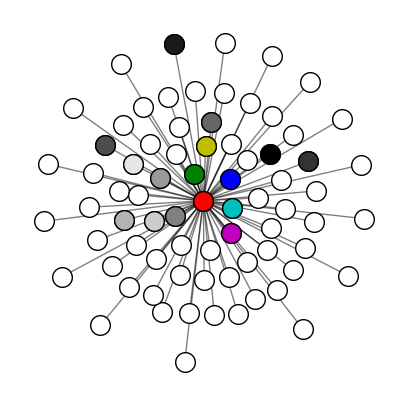

In [50]:
viz.plot_community_graph(g, lp_coms, figsize=(5, 5), min_size=3)

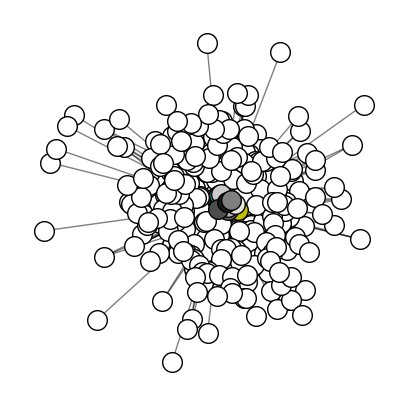

In [51]:
viz.plot_community_graph(g, infomap_coms, figsize=(5, 5), min_size=3)

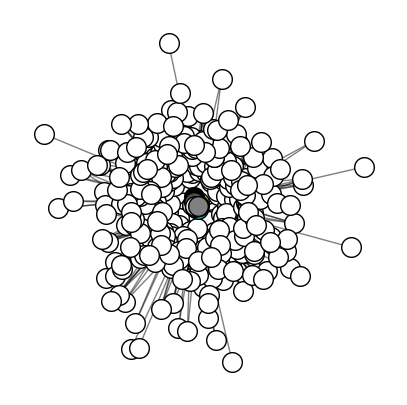

In [52]:
viz.plot_community_graph(g, infomap_coms_weighted, figsize=(5, 5), min_size=3)

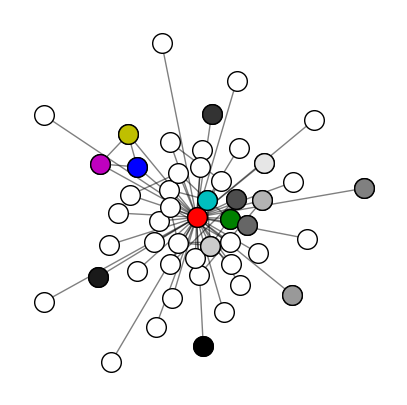

In [47]:
viz.plot_community_graph(g_copy, angel_coms, figsize=(5, 5), min_size=1)

## Ground truth evaluation

We select the nodes that have the different attributes

In [25]:

covid_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('covid') == 1]
fiveg_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('fiveg') == 1]
alien_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('alien') == 1]
chem_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('chem') == 1]
flat_earth_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('flat_earth') == 1]
religion_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('religion') == 1]
neutral_nodes = [node for node, attributes in g.nodes(data=True) if attributes.get('neutral') == 1]


Definition of the communities partitioning the nodes referring their attributes 

In [29]:
communities = [covid_nodes, fiveg_nodes, alien_nodes, chem_nodes, flat_earth_nodes, neutral_nodes, religion_nodes]
ground_truth_coms = NodeClustering(communities, graph=None, method_name="ground_truth_coms")

We compare this communities with demon and angel communities

In [34]:
print(evaluation.overlapping_normalized_mutual_information_LFK(ground_truth_coms,angel_coms))
print(evaluation.overlapping_normalized_mutual_information_LFK(ground_truth_coms,demon_coms))

MatchingResult(score=0.014055244505339237, std=None)
MatchingResult(score=0.01291486693076671, std=None)
